# Analisis para cuantificar el contenido ofensivo en las "Reviews"

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word
from sklearn.externals import joblib
import json
import cx_Oracle
import nltk

### SQL para todas las review

Obtener la totaldad de las reviews en DWH de infojobs

In [2]:
#TODAS LAS REVIEWS EXISTENTES EN DWH
con =  cx_Oracle.connect('comprasweb_ij/Xxxx1234!@10.10.2.223/MKTG')
print(con.version)

df = pd.read_sql_query('''
SELECT * 
FROM 
(
SELECT 
	RATINGEVENTOBJECTTARGETID,
	s.DT,
	TRUNC(s.RATINGEVENTOBJECTINSTANT) AS fecha_review,
	s.RATINGEVENTOBJECTSCORE,
	REPLACE(REPLACE(s.REVIEWNAME, '?', 'n'),'n', 'n') AS REVIEWNAME,
    REPLACE(REPLACE(s.REVIEWVALUE, '?', 'n'),'n', 'n') AS REVIEWVALUE
FROM DWHPRO.COMPANY_REVIEW s 
)t 
pivot (
min(REVIEWVALUE) value FOR REVIEWNAME IN ('title', 'description')
)
''', con)

df_save = df

con.close()

11.2.0.3.0


In [3]:
df.shape

(1636215, 6)

In [4]:
#rename para los merge entre df
df = df.rename(columns={"RATINGEVENTOBJECTTARGETID": "EXPERIENCE_ID"
                            ,"DT": "FECHA"
                            ,"RATINGEVENTOBJECTSCORE": "RATING"
                            ,"'title'_VALUE": "TITLE"
                            ,"'description'_VALUE": "DESCRIPTION"
                           })

In [5]:
#df['T+D'] = df[['TITLE', 'DESCRIPTION']].apply(lambda x: ''.join(x), axis=1)
df['TD'] = df.TITLE.astype(str).str.cat(df.DESCRIPTION.astype(str), sep=' ')

#### Flag para aquellas con score menor a 3

Se crea este True/False segun las estrellas para contrastar la informacion de contenido ofensivo ya que es posible que estas reviews tenga una valoracion baja

In [6]:
df["is_bad_review"] = df["RATING"].apply(lambda x: 1 if x < 3 else 0)
df.head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review
0,24326061658,2019-01-13,2019-01-13,5,df,df,df df,0
1,34191592200,2019-01-13,2019-01-13,5,Muy buena,"Buenas condiciones, trato, profesionalidad","Muy buena Buenas condiciones, trato, profesion...",0
2,34191589955,2019-01-13,2019-01-13,3,Compa?erismi,Una empresa bastante grande con muchos trabaja...,Compa?erismi Una empresa bastante grande con m...,0
3,34191631675,2019-01-14,2019-01-14,3,.,.,. .,0
4,34198040437,2019-08-20,2019-08-20,5,Muy buena,Muy buena,Muy buena Muy buena,0


In [7]:
#quitar caracteres extraños de la bbdd manualmente (no es un tratamiento de texto, es un error en el ETL)
df["TD"] = df["TD"].apply(lambda x: 
x.replace("!", "").replace("?", "n").replace("Enter", "").replace("enter", "").replace("None", "").replace("#", "")
)

In [8]:
#eliminar registros con D y T Null (descripcion + titulo)
df_example = df[df['TD'].notnull()]

In [9]:
df[df['TD'].isnull()]

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review


In [10]:
df_example = df

Existen 1,6MM de reviews, este numero es el total sin considerar la normalización de compañias

### Limpieza de texto y reduccion de palabras

In [11]:
import string
punctuation=string.punctuation

In [12]:
from nltk.corpus import stopwords

In [13]:
stop = stopwords.words('spanish')

In [14]:
#modelo en español
import spacy
nlp = spacy.load('es_core_news_sm')

In [15]:
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop and tok not in punctuation]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)

Se agrega una nueva columna para futuros analisis con el texto limpio (sin puntuaciones, stopword, numeros, entre otros)

In [16]:
df_example['clean_text'] = df_example['TD'].apply(lambda x: cleanup_text(x, False))

In [17]:
df_example.to_csv('df_example.csv', index= False)
#, sep=';')

In [592]:
#Load the data con listado de insultos 
df_example = pd.read_csv('df_example.csv')#, encoding='latin-1', sep='|', header=None)

In [18]:
df_example.shape

(1636215, 9)

#### Cantidad de reviews por dia

In [19]:
x = df_example['FECHA'].value_counts () 
y = pd.DataFrame(x)

In [20]:
y=y.reset_index(level=0)

In [21]:
y = y.rename(columns={"index": "Fecha"
                            ,"FECHA": "count_review"
                           })

In [22]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

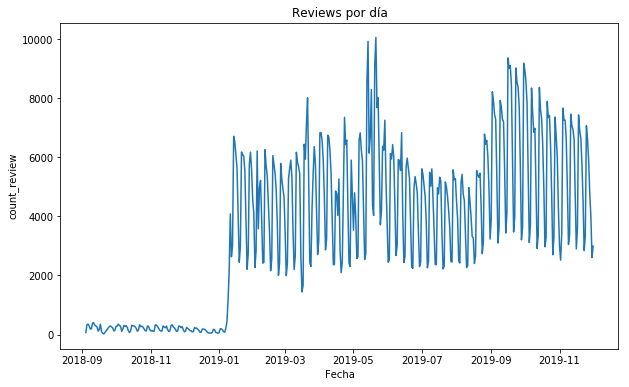

In [23]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

### Plot resultados segun Score

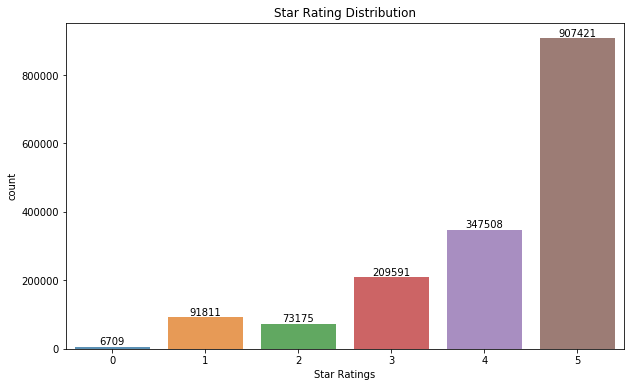

In [24]:
x = df_example['RATING'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

El potencial de Reviews con contenido prohibido son las Bad Reviews (menor a 3 estrellas) que son 91k = 1 y 73k = 2

### Agregar Blacklist para etiquetar registros con alguna de las palabras en el listado

filtro manual de una lista reducida de palabras claves

In [25]:
#Load the data con listado de insultos 
df_csv = pd.read_csv('listado_v3.csv')#, encoding='latin-1', sep='|', header=None)

In [26]:
df_csv=df_csv['Palabra_x2'].str.lower()

In [27]:
df_csv = df_csv.tolist()

Exploramos nuestra blacklist, que nos sirve para identificar revies que contengan alguna de las palabras del listado

In [29]:
lista_insultos = df_csv

In [30]:
#tokens dentro de la misma columna
def preprocessing(text):
    #text = text.decode("utf8")
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    return tokens


In [31]:
df_example['clean_text'] = df_example['clean_text'].astype(str)

In [32]:
#df_example['token_text'] = df_example['clean_text'].apply(lambda x: preprocessing(x))
df_example['token_text'] = df_example['TD'].apply(lambda x: preprocessing(x))

In [33]:
%whos

Variable         Type                    Data/Info
--------------------------------------------------
Path             type                    <class 'pathlib.Path'>
TextBlob         type                    <class 'textblob.blob.TextBlob'>
Word             type                    <class 'textblob.blob.Word'>
ax               AxesSubplot             AxesSubplot(0.125,0.125;0.775x0.755)
cleanup_text     function                <function cleanup_text at 0x1a4f2e38c8>
con              Connection              <cx_Oracle.Connection to <...>sweb_ij@10.10.2.223/MKTG>
cx_Oracle        module                  <module 'cx_Oracle' from <...>e.cpython-37m-darwin.so'>
df               DataFrame                        EXPERIENCE_ID   <...>636215 rows x 10 columns]
df_csv           list                    n=479
df_example       DataFrame                        EXPERIENCE_ID   <...>636215 rows x 10 columns]
df_save          DataFrame                        RATINGEVENTOBJEC<...>1636215 rows x 6 columns]

Agregar nueva columna True/False, que busca dentro del texto que haga match con alguna palabra de la blacklist

In [34]:
#Funcion que busca alguna palabra dentro de cada registro y que pertenezca al listado de insultos
df_example['es_insulto'] = df_example['token_text'].apply(lambda x: any([k in x for k in lista_insultos]))

### Plot del listado vs el total de reviews

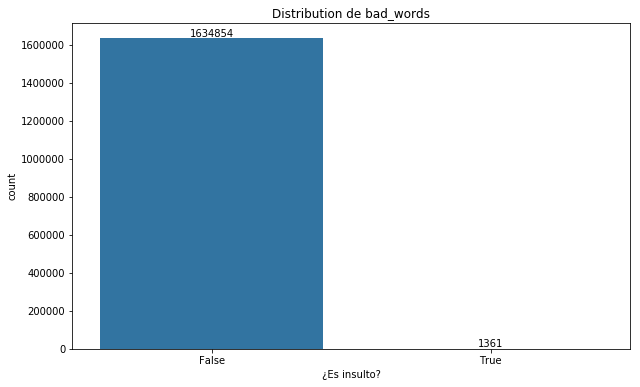

In [35]:
x = df_example['es_insulto'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 1) 
plt.title ("Distribution de bad_words") 
plt.ylabel ('count') 
plt.xlabel ('¿Es insulto?') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Este primer paso encuentra 1361

reviews con posibles insultos en su contenido

#### Ver en profundidad si estos insultos tienen una nota mayor o menor a 3

In [36]:
#dataframe con solo insulto = True
df_insultos = df_example[df_example['es_insulto']==True]

In [37]:
df_insultos.to_csv('df_insultos_dicc_2.csv', index= False)
#, sep=';')

In [38]:
df_insultos.shape

(1361, 11)

In [39]:
df_insultos[df_insultos['is_bad_review']==0].head(7)

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto
869,34199066747,2019-09-19,2019-09-19,3,Estresante.,La satisfaccion de trabajar con personas que n...,Estresante. La satisfaccion de trabajar con pe...,0,estresante satisfaccion trabajar personar nece...,"[Estresante, ., La, satisfaccion, de, trabajar...",True
11076,34195671537,2019-05-20,2019-05-20,3,Buenos compa?eros y siempre satisfactorio trab...,Dificil compatibilizar con otros empleos si no...,Buenos companeros y siempre satisfactorio trab...,0,buenos companeros siempre satisfactorio trabaj...,"[Buenos, companeros, y, siempre, satisfactorio...",True
14620,34199146745,2019-09-21,2019-09-21,5,empresa ejemplar,muy buen trato a sus trabajadores y pagan todo...,empresa ejemplar muy buen trato a sus trabajad...,0,empresa ejemplar bueno tratar trabajador pagar...,"[empresa, ejemplar, muy, buen, trato, a, sus, ...",True
19407,34201092287,2019-11-14,2019-11-14,3,100% recomendado una experiencia nueva,Bien aprendi mucho sobre el sector de la hoste...,100% recomendado una experiencia nueva Bien ap...,0,100 recomendar experiencia nuevo bien aprendi ...,"[100, %, recomendado, una, experiencia, nueva,...",True
22973,34201350973,2019-11-22,2019-11-22,4,Regular,Un trabajo temporal que dependiendo del local ...,Regular Un trabajo temporal que dependiendo de...,0,regular trabajar temporal depender local tocar...,"[Regular, Un, trabajo, temporal, que, dependie...",True
23870,34201349019,2019-11-22,2019-11-22,3,pagos retrasados,"La empresa, ha ido en caida.","pagos retrasados La empresa, ha ido en caida.",0,pago retrasar empresa haber ir caida,"[pagos, retrasados, La, empresa, ,, ha, ido, e...",True
24324,34196597363,2019-06-19,2019-06-19,4,Me formo en mis practicas,Una empresa que me ayudo a desarrollar mis put...,Me formo en mis practicas Una empresa que me a...,0,formar practicar empresa ayudar desarrollar pu...,"[Me, formo, en, mis, practicas, Una, empresa, ...",True


Ahora que tenemos este nuevo dataframe vamos a ver la distribucion segun las estrellas de cada valoracion

### Plot de flag = true y con score menor a 3

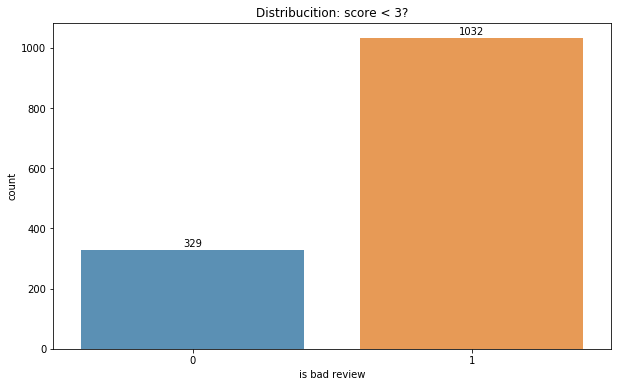

In [40]:
x = df_insultos['is_bad_review'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Distribucition: score < 3?") 
plt.ylabel ('count') 
plt.xlabel ('is bad review') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Existen 950 reviews, las cuales tienen alguna palabra ofensiva y ademas tienen una puntuacion menor a 3 estrellas

In [41]:
x = df_insultos['FECHA'].value_counts () 
y = pd.DataFrame(x)

In [42]:
y=y.reset_index(level=0)

In [43]:
y = y.rename(columns={"index": "Fecha"
                            ,"FECHA": "count_review"
                           })

In [44]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

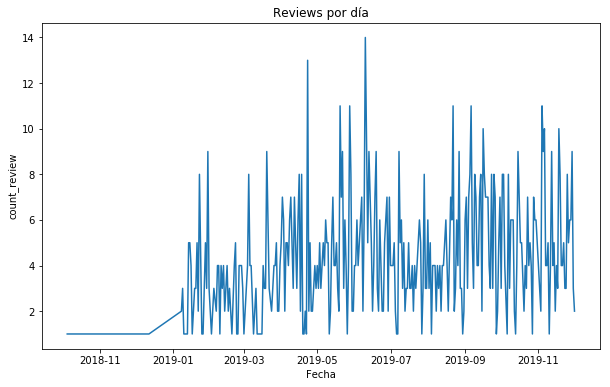

In [45]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

Diariamente no hay mas de 15 Reviews consideradas ofensivas con este primer modelo

### Ahora el mismo analisis pero con Normalizacion de Empresas

el modelo anterior considera todas las posibles reviews (lo cual debe ser), solo se hará este paso con empresas normalizadas ya que es lo que realmente se esta pintando. Para analizar las reviews se debe considerar el volumen TOTAL

In [46]:
#Load the data
df_company_reviews = pd.read_csv('reviews_all_df.csv')#, encoding='', sep='|', header=None)

In [47]:
df_company_reviews.shape

(548272, 8)

se reduce la cantidad de 1,5MM a 548k de reviews, todo el resto no cruza con empresas normalizas por lo cual no se pueden pintar

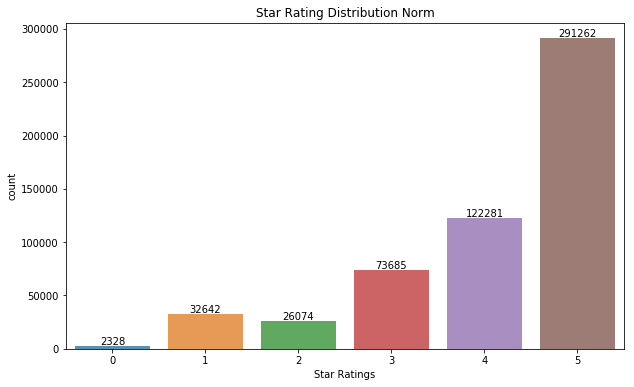

In [48]:
x = df_company_reviews['SCORE'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution Norm") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

potencial de revies con contenido ofensivo 32k + 26k

Si queremos ver por dia:

In [49]:
x = df_company_reviews['DATE_REVIEW'].value_counts () 
y = pd.DataFrame(x)

In [50]:
y=y.reset_index(level=0)

In [51]:
y = y.rename(columns={"index": "Fecha"
                            ,"DATE_REVIEW": "count_review"
                           })

In [52]:
y['Fecha'] = pd.to_datetime(y['Fecha'])

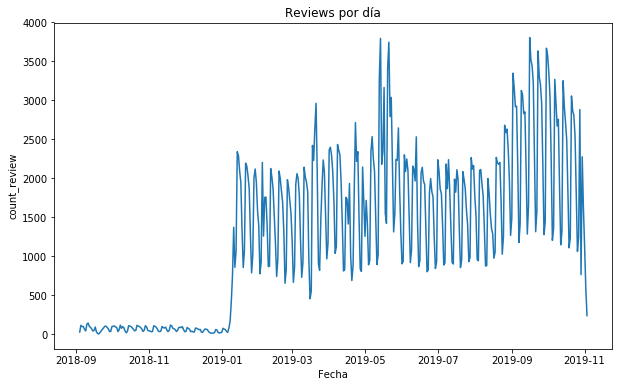

In [53]:
plt.figure(figsize = (10,6)) 
plt.title ("Reviews por día") 
ax = sns.lineplot(x="Fecha", y="count_review", data=y)

Actualmente no supera las 4000 reviews normalizadas por dia

A continuacion se aplica la misma funcion que detecta el contenido dentro de la review con alguna palabra de la blacklist

In [54]:
#df['T+D'] = df[['TITLE', 'DESCRIPTION']].apply(lambda x: ''.join(x), axis=1)
df_company_reviews['TD'] = df_company_reviews.TITLE.astype(str).str.cat(df_company_reviews.DESCRIPTION.astype(str), sep=' ')

In [55]:
df_company_reviews = df_company_reviews[df_company_reviews['TD'].notnull()]

In [56]:
df_company_reviews['clean_text'] = df_company_reviews['TD'].apply(lambda x: cleanup_text(x, False))

In [57]:
df_company_reviews['token_text'] = df_company_reviews['clean_text'].apply(lambda x: preprocessing(x))

In [58]:
df_company_reviews['es_insulto'] = df_company_reviews['token_text'].apply(lambda x: 
                                                                          any([k in x for k in lista_insultos]))

In [59]:
df_company_reviews["is_bad_review"] = df_company_reviews["SCORE"].apply(lambda x: 1 if x < 3 else 0)

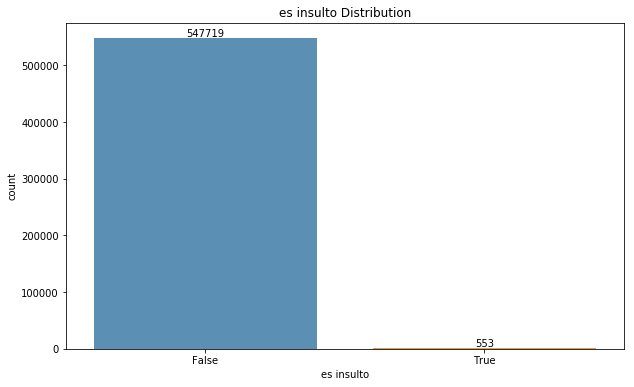

In [60]:
x = df_company_reviews['es_insulto'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('es insulto') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Se detectan 540 reviews normalizadas con posible contenido ofensivo

In [61]:
df_insultos_norm = df_company_reviews[df_company_reviews['es_insulto']==True]

In [62]:
df_insultos_norm.shape

(553, 13)

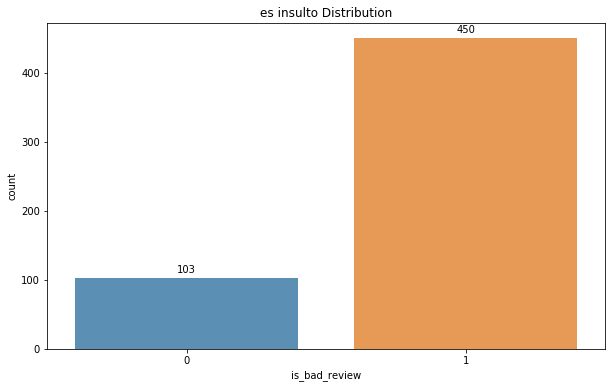

In [63]:
x = df_insultos_norm['is_bad_review'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("es insulto Distribution") 
plt.ylabel ('count') 
plt.xlabel ('is_bad_review') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

de las cuales 250 tienen una puntuacion menor a 3 estrellas.

Exportamos nuestros ID para hacer el cruce en el dashboard:

In [64]:
id_bad_reviews = df_insultos[['EXPERIENCE_ID']]

In [65]:
df_insultos.head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto
869,34199066747,2019-09-19,2019-09-19,3,Estresante.,La satisfaccion de trabajar con personas que n...,Estresante. La satisfaccion de trabajar con pe...,0,estresante satisfaccion trabajar personar nece...,"[Estresante, ., La, satisfaccion, de, trabajar...",True
1850,34198200321,2019-09-14,2019-09-14,1,"Sueldo mal pagado, horas extras no pagadas, ma...",Personalmente a mi me ofrecieron unas condicio...,"Sueldo mal pagado, horas extras no pagadas, ma...",1,sueldo mal pagar hora extra pagar mal tratar t...,"[Sueldo, mal, pagado, ,, horas, extras, no, pa...",True
1938,33610057044,2018-10-22,2018-10-22,2,Tipo de contrato inicial deberia ser indefinid...,Me parece bastante feo que hagan contratos en ...,Tipo de contrato inicial deberia ser indefinid...,1,tipo contratar inicial deberia ser indefinido ...,"[Tipo, de, contrato, inicial, deberia, ser, in...",True
3581,34197931950,2019-08-14,2019-08-14,1,muy mala la valoracion,una mierda,muy mala la valoracion una mierda,1,malo valoracion mierda,"[muy, mala, la, valoracion, una, mierda]",True
5162,30113280474,2019-10-09,2019-10-09,1,lo mas importante es comerle los huevos a los ...,Empresa dediacada a la distribucion de recambi...,lo mas importante es comerle los huevos a los ...,1,mas importante ser comerle huevo jefe secretar...,"[lo, mas, importante, es, comerle, los, huevos...",True


In [66]:
id_bad_reviews.to_csv('id_bad_reviews.csv', index= False)
#, sep=';')

## Analizar distribucion de reviews con caracteres especiales

#### Para detectar Emails, caracteres repetidos, numeros y puntos.

In [67]:
import re

df = pd.DataFrame({'Name': ['Amy', 'Ben', 'Christine', 'David'],
                    'review': ['hola estaa!, review es ejemplo.',
                              '-.,!"·$%"',
                              'hola cris@hola.com',
                              'AA aaaaaaaasssssssaaaaaaaa']},
                    columns=['Name', 'review'])
df

#p = r'[a-z._0-9]+@[a-z]+\.[a-z]{2,3}' # emails
p = r'^[\W_0-9]+$' #solo numeros y/o caracteres especiales como -.,!"·$%"' o %&23,$3253$56%
#p = r'^[0-9]+$' #numeros... mejor la anterior ya que cumple con ambos criterios
#p = r'(.)\1{2,}' #algun caracter duplicado mas de dos veces por ejemplo "hooola"

#p =r'^[0-9 .,!-*%&]+$' #numeros y algunos puntos (para decimales por ejemplo)

#df['out'] = df['review'].astype(str).str.lower().apply(lambda x: re.search(p, x))
df['out'] = df['review'].apply(lambda x: re.search(p, x))
df

,Name,review,out
0,Amy,"hola estaa!, review es ejemplo.",None
1,Ben,"-.,!""·$%""","<re.Match object; span=(0, 9), match='-.,!""·$%""'>"
2,Christine,hola cris@hola.com,None
3,David,AA aaaaaaaasssssssaaaaaaaa,None


Esta parte solo hace match con caractere especiales y  numeros

In [68]:
df_final = df_example #guardar paso anterior

In [69]:
df_final['TITLE'] = df_final['TITLE'].astype(str)
df_final['DESCRIPTION'] = df_final['DESCRIPTION'].astype(str)

In [70]:
p = r'^[\W_0-9]+$'

df_final['title_is_punct'] = df_final['TITLE'].apply(lambda x: re.search(p, x))
df_final['title_is_punct'] = df_final['title_is_punct'].apply(lambda x: True if x != None else False)

df_final['desc_is_punct'] = df_final['DESCRIPTION'].apply(lambda x: re.search(p, x))
df_final['desc_is_punct'] = df_final['desc_is_punct'].apply(lambda x: True if x != None else False)

In [71]:
df_final[(df_final['title_is_punct']==True)&(df_final['desc_is_punct']==True)].head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto,title_is_punct,desc_is_punct
3,34191631675,2019-01-14,2019-01-14,3,.,.,. .,0,,"[., .]",False,True,True
14,34198055010,2019-08-20,2019-08-20,1,0,0,0 0,1,0 0,"[0, 0]",False,True,True
38,34199791155,2019-10-07,2019-10-07,3,8,8,8 8,0,8 8,"[8, 8]",False,True,True
48,34192317187,2019-02-01,2019-02-01,5,.,.,. .,0,,"[., .]",False,True,True
57,34198159219,2019-08-25,2019-08-25,3,.,.,. .,0,,"[., .]",False,True,True


Analizar de que plataforma provienen estas review (Titulo y desc con caracteres especiales)

In [46]:
df_puntos = df_final[(df_final['title_is_punct']==True)&(df_final['desc_is_punct']==True)]

In [47]:
#TODAS LAS REVIEWS EXISTENTES EN DWH y su plataforma
con =  cx_Oracle.connect('comprasweb_ij/Xxxx1234!@10.10.2.223/MKTG')
print(con.version)

df_platform = pd.read_sql_query('''
SELECT 
RATINGEVENTOBJECTTARGETID as EXPERIENCE_ID
,PROVIDERCHANNEL
FROM 
DWHPRO.COMPANY_REVIEW
GROUP BY 
RATINGEVENTOBJECTTARGETID
,PROVIDERCHANNEL
''', con)

con.close()

11.2.0.3.0


In [48]:
df_platform.shape

(1636184, 2)

In [49]:
df_puntos = df_puntos.merge(df_platform,how='left',on = 'EXPERIENCE_ID')

In [50]:
df_puntos.to_csv('df_puntos.csv', index= False)
#, sep=';')

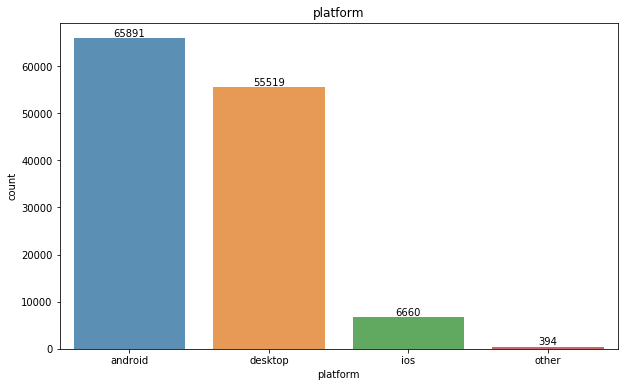

In [51]:
x = df_puntos['PROVIDERCHANNEL'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("platform") 
plt.ylabel ('count') 
plt.xlabel ('platform') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

In [52]:
df_example = df_example.merge(df_platform,how='left',on = 'EXPERIENCE_ID')

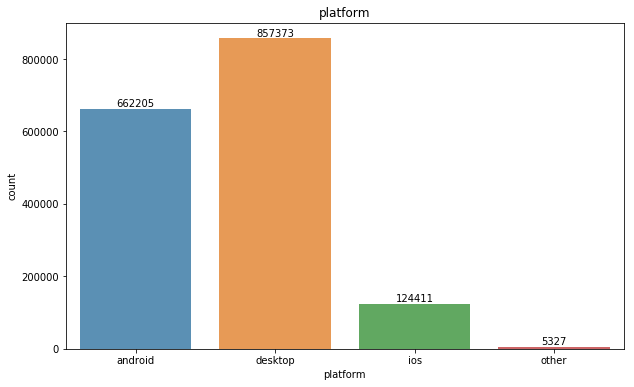

In [53]:
x = df_example['PROVIDERCHANNEL'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("platform") 
plt.ylabel ('count') 
plt.xlabel ('platform') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

Ratio por Plataforma:

In [54]:
print('Android: ' + str(round(65.891 / 662.205 * 100,2)) + '%')
print('Desktop: ' + str(round(55.519 / 857.373 * 100,2)) + '%')
print('iOS: ' + str(round(6.660 / 124.411 * 100,2)) + '%')

Android: 9.95%
Desktop: 6.48%
iOS: 5.35%


In [55]:
df_2 = df_final #Save df

In [72]:
def short_text(text):
    if str.lower(text) == 'ok':
        is_short_text = False
    elif str.lower(text) == 'ok.':
        is_short_text = False
    elif str.lower(text) == 'mal':
        is_short_text = False
    elif len(text) < 4:
        is_short_text = True
    elif (text) == 'None':
        is_short_text = True
    else:
        is_short_text = False
    return is_short_text  

In [ ]:
#OMITO ESTE PASO YA QUE NO ME INTERESA SABER LA CANTIDAD DE REVIEWS CON OK O MAL, Y LO HAGO POR FUNCION TRUE/FALSE.
df_final['title_is_ok'] = df_final['TITLE'].apply(lambda x: True if str.lower(x) == 'ok' else False)
df_final['desc_is_ok'] = df_final['DESCRIPTION'].apply(lambda x: True if str.lower(x) == 'ok' else False)
df_final['title_is_mal'] = df_final['TITLE'].apply(lambda x: True if str.lower(x) == 'mal' else False)
df_final['desc_is_mal'] = df_final['DESCRIPTION'].apply(lambda x: True if str.lower(x) == 'mal' else False)
#df_final['is_short_title'] = df_final['TITLE'].str.len()
#df_final['is_short_desc'] = df_final['DESCRIPTION'].str.len()
#df_final['is_short_title']=df_final['is_short_title'].apply(lambda x: True if x < 4 else False)
#df_final['is_short_desc']=df_final['is_short_desc'].apply(lambda x: True if x < 4 else False)
df_final['is_short_title']=df_final.TITLE.apply(len).apply(lambda x: True if x < 4 else False)
df_final['is_short_desc']=df_final.DESCRIPTION.apply(len).apply(lambda x: True if x < 4 else False)

In [73]:
df_final['is_short_title']=df_final.TITLE.apply(lambda x: short_text(x))
df_final['is_short_desc']=df_final.DESCRIPTION.apply(lambda x: short_text(x))

Detectar si algun caractes esta repetido mas de dos veces, (ej: "Hooola" o "aaaaa" o "--....")

In [74]:
p = r'(.)\1{2,}'

df_final['title_is_rep'] = df_final['TITLE'].apply(lambda x: re.search(p, x))
df_final['title_is_rep'] = df_final['title_is_rep'].apply(lambda x: True if x != None else False)

df_final['desc_is_rep'] = df_final['DESCRIPTION'].apply(lambda x: re.search(p, x))
df_final['desc_is_rep'] = df_final['desc_is_rep'].apply(lambda x: True if x != None else False)

In [75]:
#explorar la data...
#Parte del largo del titulo
df_final[((df_final['is_short_title']==False) 
         &(df_final['is_short_desc']==False))
         #parte de los puntos y numeros
                  &((df_final['title_is_punct']==False)
                  &(df_final['desc_is_punct']==False))
         #parte de caracteres repetidos
                           &((df_final['title_is_rep']==True)
                           &(df_final['desc_is_rep']==True))
         #parte del insulto
                               &(df_final['es_insulto']==False)
        ].sample(n=500,random_state=1).head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto,title_is_punct,desc_is_punct,is_short_title,is_short_desc,title_is_rep,desc_is_rep
446379,34196390019,2019-06-12,2019-06-12,5,oportunidade de aprender y reconocer trabajo...,"oportunidade de crescer y aprender, cambiar de...",oportunidade de aprender y reconocer trabajo.....,0,oportunidade aprender reconocer trabajar ... o...,"[oportunidade, de, aprender, y, reconocer, tra...",False,False,False,False,False,True,True
532337,34194034818,2019-03-25,2019-03-25,5,es una muy buena porque sabes trabajar tamb,Lo positivo de trabajar en Burguer King es la ...,es una muy buena porque sabes trabajar tamb ...,0,ser bueno saber trabajar tamb positivo trabaja...,"[es, una, muy, buena, porque, sabes, trabajar,...",False,False,False,False,False,True,True
1154109,34196407000,2019-06-12,2019-06-12,1,xxxx,Xxxx,xxxx Xxxx,1,xxxx xxxx,"[xxxx, Xxxx]",False,False,False,False,False,True,True
41819,34199540171,2019-10-01,2019-10-01,5,hvvhhhhhhjj,ggggggg,hvvhhhhhhjj ggggggg,0,hvvhhhhhhjj ggggggg,"[hvvhhhhhhjj, ggggggg]",False,False,False,False,False,True,True
562700,34194803413,2019-04-19,2019-04-19,4,Xxxx,Xxxx,Xxxx Xxxx,0,xxxx xxxx,"[Xxxx, Xxxx]",False,False,False,False,False,True,True


In [76]:
df_final.head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,token_text,es_insulto,title_is_punct,desc_is_punct,is_short_title,is_short_desc,title_is_rep,desc_is_rep
0,24326061658,2019-01-13,2019-01-13,5,df,df,df df,0,df df,"[df, df]",False,False,False,True,True,False,False
1,34191592200,2019-01-13,2019-01-13,5,Muy buena,"Buenas condiciones, trato, profesionalidad","Muy buena Buenas condiciones, trato, profesion...",0,bueno buenas condicionar tratar profesionalidad,"[Muy, buena, Buenas, condiciones, ,, trato, ,,...",False,False,False,False,False,False,False
2,34191589955,2019-01-13,2019-01-13,3,Compa?erismi,Una empresa bastante grande con muchos trabaja...,Companerismi Una empresa bastante grande con m...,0,companerismi empresa bastante grande trabajado...,"[Companerismi, Una, empresa, bastante, grande,...",False,False,False,False,False,False,False
3,34191631675,2019-01-14,2019-01-14,3,.,.,. .,0,,"[., .]",False,True,True,True,True,False,False
4,34198040437,2019-08-20,2019-08-20,5,Muy buena,Muy buena,Muy buena Muy buena,0,bueno bueno,"[Muy, buena, Muy, buena]",False,False,False,False,False,False,False


In [77]:
for col in df_final.columns: 
    print(col)

EXPERIENCE_ID
FECHA
FECHA_REVIEW
RATING
TITLE
DESCRIPTION
TD
is_bad_review
clean_text
token_text
es_insulto
title_is_punct
desc_is_punct
is_short_title
is_short_desc
title_is_rep
desc_is_rep


In [78]:
df_final.to_csv('df_final_matriz.csv', index= True)
#, sep=';')

#### Definir funcion para etiquetar una review como: Aprobada, Moderacion manual y Rechazada.

In [79]:
#explorar la data...
#Parte del largo del titulo
df_sample = df_final[((df_final['is_short_title']==False) 
         &(df_final['is_short_desc']==False))
         #parte de los puntos y numeros
                  &((df_final['title_is_punct']==False)
                  &(df_final['desc_is_punct']==False))
         #parte de caracteres repetidos
                           &((df_final['title_is_rep']==False)
                           &(df_final['desc_is_rep']==False))
         #parte del insulto
                               &(df_final['es_insulto']==False)
         #nota de la review
         #                          &((df_final['RATING']==1) | (df_final['RATING']==2))
        ].iloc[:,:].sample(n=500,random_state=1)

In [80]:
df_sample.to_csv('sample_500_random.csv', index= True)
#, sep=';')

In [81]:
#explorar la data...
#Parte del largo del titulo
df_sample = df_final[(df_final['RATING']==2)
        ].iloc[:,:6].sample(n=500,random_state=1)

In [82]:
df_sample.head()

,EXPERIENCE_ID,FECHA,FECHA_REVIEW,RATING,TITLE,DESCRIPTION
1479263,34194585663,2019-04-10,2019-04-10,2,gran experiencia,gran experiencia
755562,32316233100,2019-08-29,2019-08-29,2,exigen mucho para no percibir por lo trabajado,Me parece una empresa que se trabaja muchas ho...
1547949,33520686602,2019-07-17,2019-07-17,2,empresa muy grande. mucha suciedad en el ambiente,empresa muy grande. mucha suciedad en el ambiente
701589,34195817523,2019-05-23,2019-05-23,2,Buenas profesionales,.
1296658,34199065324,2019-10-10,2019-10-10,2,Bien todo,Bien
